# Assignment 4: Tracking, Time-resolved microscopy

In [513]:
import diplib as dip
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
from scipy.ndimage import rotate

In [514]:
img_folder = 'images/'
fn_pattern = 'MTLn3{group}00{num}.tif'
group_names = {'egf': '+egf', 'ctrl': '-ctrl'}

In [515]:
def remove_border_objects(img):
    seed = np.ones(np.array(img.Sizes()) - 2)
    seed = 1 - np.pad(seed, pad_width=1)
    seed = dip.FixedThreshold(dip.Image(seed), 0.5)
    edge_objects = dip.BinaryPropagation(seed, img)
    img -= edge_objects
    return img

def calculate_difference(cell1, cell2):
    distance = (cell1['x_coord'] - cell2['x_coord']) ** 2
    distance += (cell1['y_coord'] - cell2['y_coord']) ** 2
    size_difference = np.abs(cell1['size'] - cell2['size'])
    return np.sqrt(distance) + size_difference

In [516]:
images = {'ctrl': {}, 'egf': {}}

for group in images.keys():
    for num in range(30):
        num_str = '0' + str(num) if num < 10 else str(num)
        img = dip.ImageReadTIFF(img_folder + fn_pattern.format(group=group_names[group], num=num_str))
        rescaled_img = img / 2 ** 16 # rescale to [0..1]
        grey_img = dip.ColorSpaceManager.Convert(rescaled_img, 'grey') # convert from RGB to grey-scale
        even_img = grey_img - dip.Tophat(grey_img, 10) # remove background
        images[group][num] = even_img

In [517]:
segmented = {}
for num in images['ctrl'].keys():
    img = images['ctrl'][num]
    rescaled_img = img / 2 ** 16 # rescale to [0..1]
    grey_img = dip.ColorSpaceManager.Convert(rescaled_img, 'grey') # convert from RGB to grey-scale
    even_img = grey_img - dip.Tophat(grey_img, 10) # remove background
    bin_img = dip.IsodataThreshold(even_img) # apply ISODATA threshold
    noe_img = remove_border_objects(bin_img)
    # label_img = dip.Label(noe_img, connectivity=1)
    # msr = dip.MeasurementTool.Measure(label_img, grey_img, ['Size'])
    # sizes = np.array([msr['Size'][i+1][0] for i in range(msr.NumberOfObjects())])
    # label_img2 = dip.Label(noe_img, connectivity=1, minSize=400, maxSize=600)
    # seg = np.asarray(label_img2)
    # seg[seg > 0] = 1
    # seg = dip.Image(seg)
    segmented[num] = noe_img

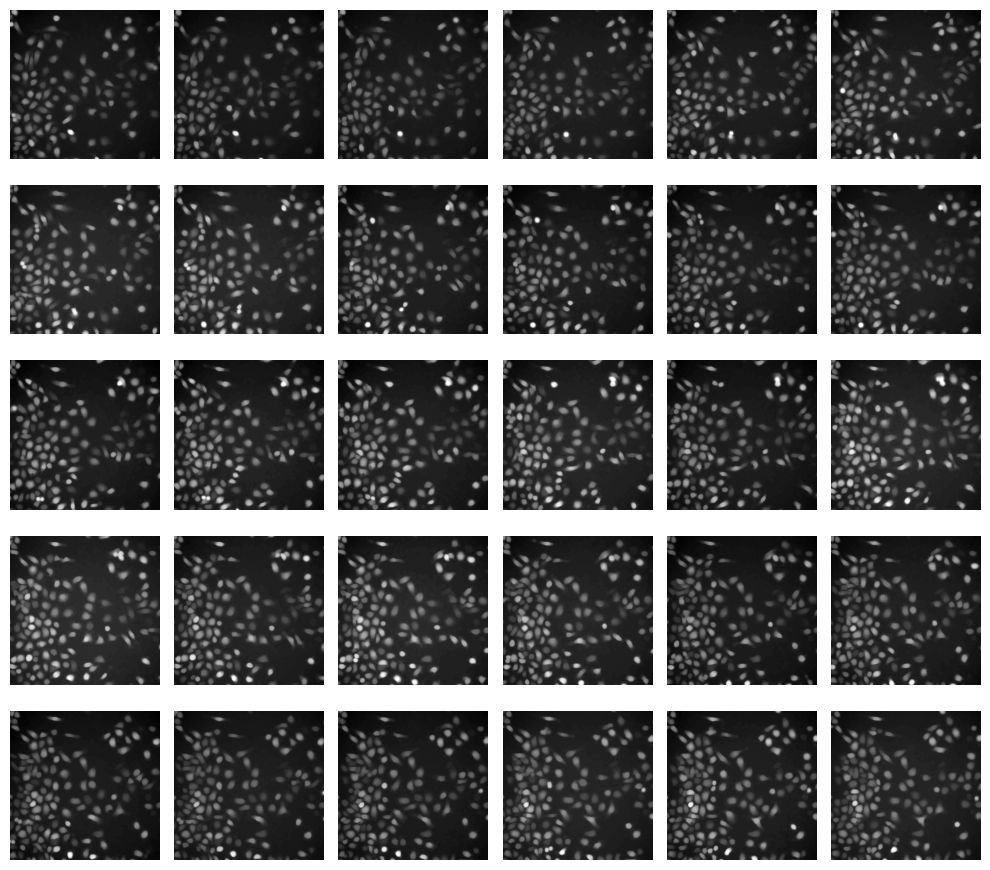

In [518]:
fig, axs = plt.subplots(5, 6, figsize=(10, 9))
axs = axs.flatten()
for i in range(30):
    axs[i].imshow(images['ctrl'][i], cmap='grey')
    axs[i].axis('off')
plt.tight_layout()
plt.show()

In [519]:
R = images['ctrl'][0]
adi_pos = np.zeros((512, 512))
adi_neg = np.zeros((512, 512))

for i in range(30):
    grad = images['ctrl'][i] - R
    grad_pos, grad_neg = np.copy(grad), np.copy(grad)
    grad_pos[grad_pos > 0.01] = 1
    grad_pos[grad_pos <= 0.01] = 0
    grad_neg[grad_neg >= -0.01] = 0
    grad_neg[grad_neg < -0.01] = 1
    adi_pos += grad_pos
    adi_neg += grad_neg

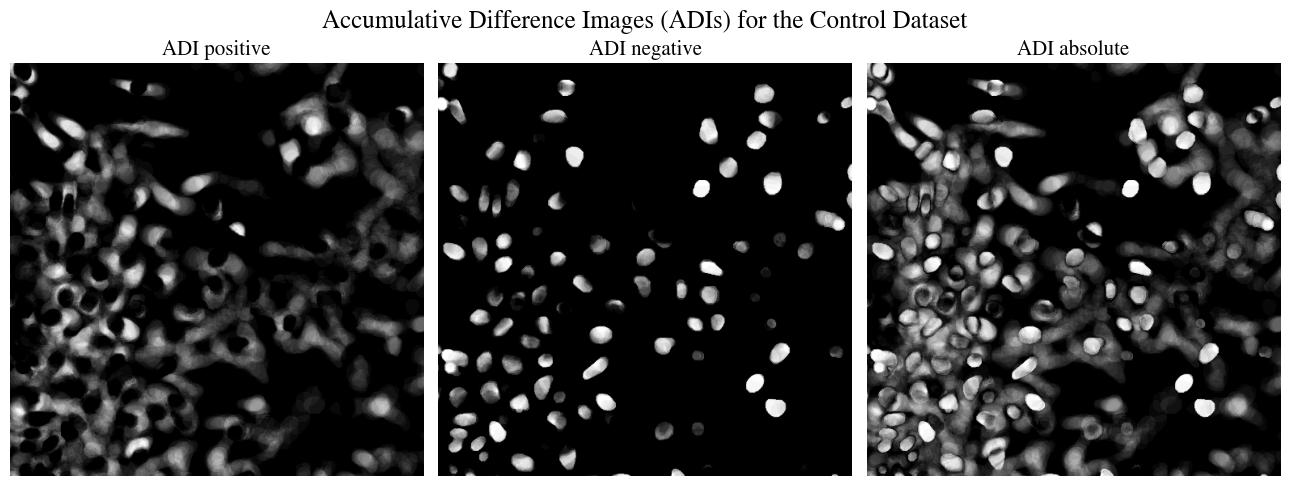

In [524]:
fig, axs = plt.subplots(1, 3, figsize=(13, 5))
axs[0].imshow(adi_pos, cmap='grey')
axs[0].set_title('ADI positive', fontname='STIXGeneral', fontsize=15)
axs[1].imshow(adi_neg, cmap='grey')
axs[1].set_title('ADI negative', fontname='STIXGeneral', fontsize=15)
axs[2].imshow(adi_pos + adi_neg, cmap='grey')
axs[2].set_title('ADI absolute', fontname='STIXGeneral', fontsize=15)

[axs[i].axis('off') for i in range(3)]
fig.suptitle('Accumulative Difference Images (ADIs) for the Control Dataset', fontname='STIXGeneral', fontsize=18)
plt.tight_layout()
plt.savefig('figures/adis.png')

In [370]:
initial_coords = [[334,  85], [168, 116], [103, 122], [413, 150],
                  [325, 155], [ 80, 221], [ 80, 249], [336, 254],
                  [ 80, 327], [422, 359], [194, 378], [391, 396],
                  [206, 419], [100, 421], [416, 426]]

In [ ]:
seeds_coords = np.array(initial_coords) + 1
mask = np.zeros((512, 512))
for loc in initial_coords:
    x, y = loc
    mask[x-1: x+1, y-1: y+1] = 1

In [373]:
labeled = dip.Label(segmented[0])
msr = dip.MeasurementTool.Measure(labeled, images['ctrl'][0], ['Size', 'Gravity'])
sizes = np.array([msr['Size'][i+1][0] for i in range(msr.NumberOfObjects())])
coords = np.array([msr['Gravity'][i+1] for i in range(msr.NumberOfObjects())])
x_coords, y_coords = coords[:, 0], coords[:, 1]

In [375]:
seed = dip.FixedThreshold(dip.Image(mask), 0.5)
seed = rotate(np.asarray(seed), 90)[::-1, :]
coi = dip.BinaryPropagation(seed, segmented[0])

In [378]:
coi_labeled = dip.Label(coi)

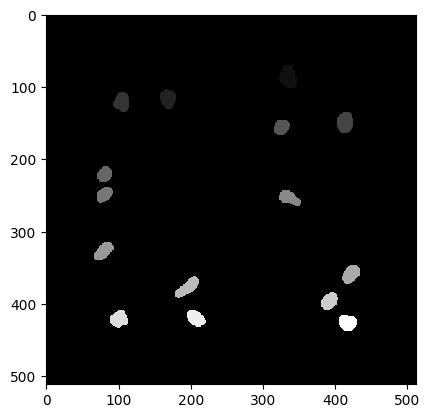

In [379]:
coi_labeled.Show()

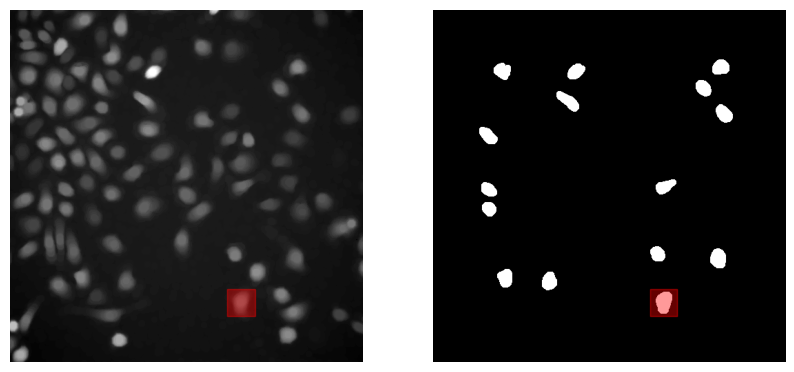

In [469]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(images['ctrl'][0], origin='lower', cmap='grey')
axs[0].axis('off')
axs[1].imshow(coi, origin='lower', cmap='grey')
axs[1].axis('off')

rect_halfsize = 20
for loc in seeds_coords:
    x, y = loc
    rect = Rectangle(xy=(x-rect_halfsize, y-rect_halfsize), width=2*rect_halfsize, height=2*rect_halfsize, color='r', alpha=0.4)
    rect2 = Rectangle(xy=(x-rect_halfsize, y-rect_halfsize), width=2*rect_halfsize, height=2*rect_halfsize, color='r', alpha=0.4)
    axs[0].add_patch(rect)
    axs[1].add_patch(rect2)
    break

In [476]:
initial_coord = initial_coords[0]

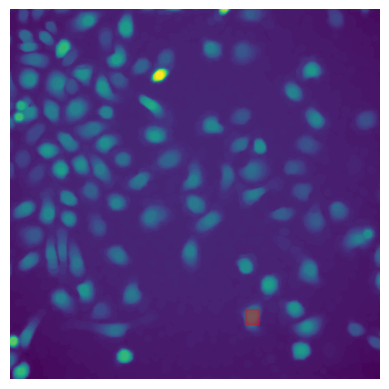

In [471]:
fig, ax = plt.subplots()
ax.imshow(images['ctrl'][0], origin='lower')
rect = Rectangle(xy=(x-10, y-10), width=20, height=20, color='r', alpha=0.4)
ax.add_patch(rect)
ax.axis('off')
plt.show()

In [554]:
x_coords, y_coords, sizes = [], [], []
labeled_archive = []
seed = np.zeros((images['ctrl'][0].Sizes()))
x, y = initial_coord
seed[x, y] = 1
seed = dip.FixedThreshold(seed, 0.5)
masked = dip.BinaryPropagation(seed, segmented[0])
labeled = dip.Label(masked, connectivity=1)
labeled_archive.append(labeled)
msr = dip.MeasurementTool.Measure(labeled, images['ctrl'][0], ['Gravity', 'Size'])
y_coord, x_coord = msr['Gravity'][1]
size = msr['Size'][1][0]
x_coords.append(int(x_coord))
y_coords.append(int(y_coord))
sizes.append(size)

In [555]:
displacement_tolerance = 10
for i in range(1, 30):
    current_cell = {'size': sizes[-1], 'x_coord': x_coords[-1], 'y_coord': y_coords[-1]}
    seed = np.zeros((images['ctrl'][0].Sizes()))
    x, y = x_coords[i-1], y_coords[i-1]
    seed[x-displacement_tolerance: x+displacement_tolerance,
        y-displacement_tolerance: y+displacement_tolerance] = 1
    seed = dip.FixedThreshold(seed, 0.5)
    masked = dip.BinaryPropagation(seed, segmented[i])
    labeled = dip.Label(masked, connectivity=1)
    labeled_archive.append(labeled)
    msr = dip.MeasurementTool.Measure(labeled, images['ctrl'][0], ['Gravity', 'Size'])
    chosen_candidate = 1
    if msr.NumberOfObjects() > 1:
        print(f"Found {msr.NumberOfObjects()} objects in photo {i}.")
        differences = [calculate_difference({'size': msr['Size'][i+1][0], 'x_coord': msr['Gravity'][i+1][1], 'y_coord': msr['Gravity'][i+1][0]},
                                            current_cell) for i in range(msr.NumberOfObjects())]
        chosen_candidate = np.argmin(differences) + 1
        
    if msr.NumberOfObjects() < 1:
        print(f"Found no objects in photo {i}.")
    y_coord, x_coord = msr['Gravity'][chosen_candidate]
    size = msr['Size'][chosen_candidate][0]
    x_coords.append(int(x_coord))
    y_coords.append(int(y_coord))
    sizes.append(size)

Found 2 objects in photo 1.
Found 2 objects in photo 4.
Found 2 objects in photo 14.


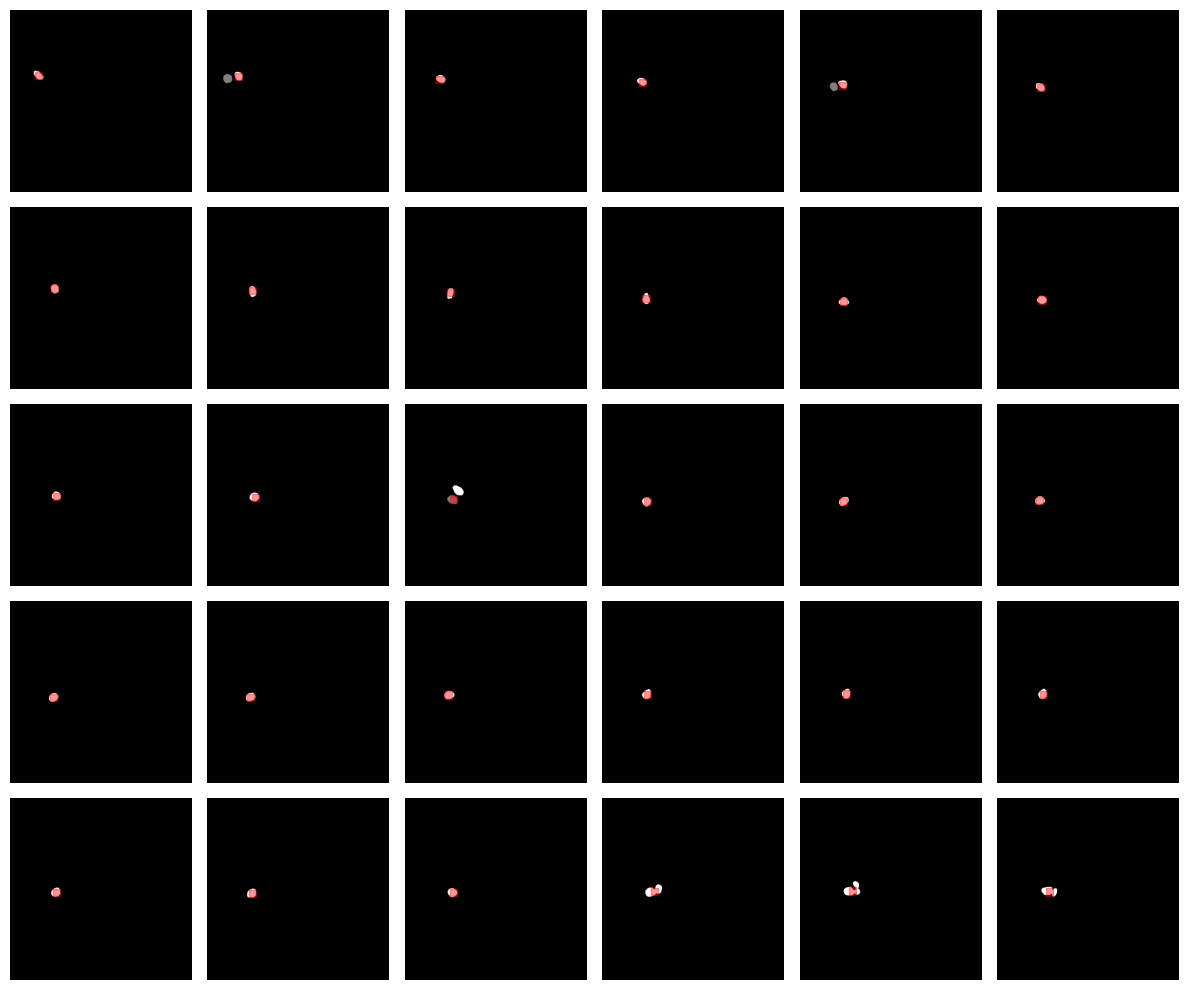

In [560]:
fig, axs = plt.subplots(5, 6, figsize=(12, 10))
axs = axs.flatten()
for i in range(len(labeled_archive)):
    axs[i].imshow(labeled_archive[i], origin='lower', cmap='grey')
    rect = Rectangle(xy=(y_coords[i] - 10, x_coords[i] - 10), width=20, height=20, color='r', alpha=0.4)
    axs[i].add_patch(rect)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [561]:
summed_img = labeled_archive[0]
for i in range(1, len(labeled_archive)):
    summed_img += labeled_archive[i]


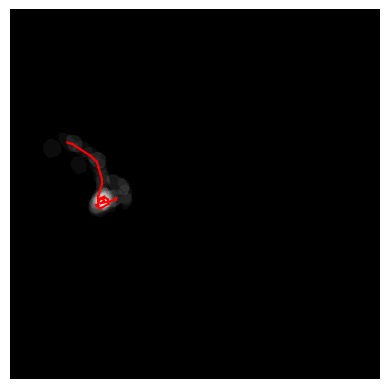

In [571]:
fig, ax = plt.subplots()
ax.imshow(summed_img, origin='lower', cmap='grey')
for i in range(len(x_coords) - 1):
    ax.plot([y_coords[i], y_coords[i+1]], [x_coords[i], x_coords[i+1]], c='r')
ax.axis('off')
plt.show()

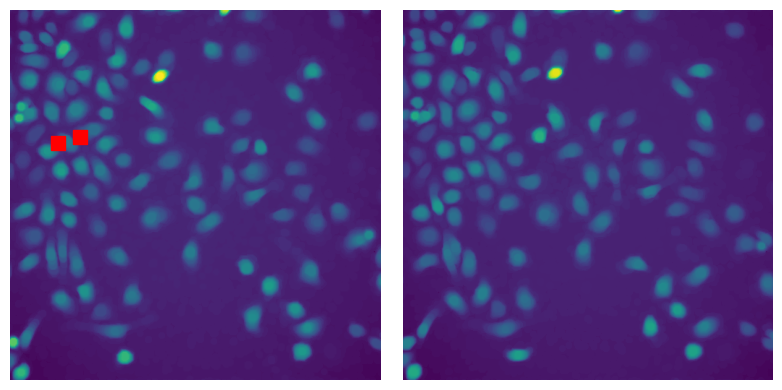

In [494]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(images['ctrl'][0], origin='lower')
for i in range(2):
    rect = Rectangle(xy=(coords[i][0], coords[i][1]), width=20, height=20, color='r')
    axs[0].add_patch(rect)
axs[1].imshow(images['ctrl'][1], origin='lower')
[axs[i].axis('off') for i in range(len(axs))]
plt.tight_layout()
plt.show()

In [482]:
displacement_tolerance = 10
for i in range(1, 30):
    seed = np.zeros((images['ctrl'][0].Sizes()))
    x, y = x_coords[i-1], y_coords[i-1]
    seed[x-displacement_tolerance: x+displacement_tolerance,
         y-displacement_tolerance: y+displacement_tolerance] = 1
    seed = dip.FixedThreshold(seed, 0.5)
    masked = dip.BinaryPropagation(seed, segmented[i])
    labeled = dip.Label(masked, connectivity=1)
    msr = dip.MeasurementTool.Measure(labeled, images['ctrl'][0], ['Gravity', 'Size'])
    if msr.NumberOfObjects() != 1:
        print(f"Found {msr.NumberOfObjects()} objects in photo {i}.")
    x_coord, y_coord = msr['Gravity'][1]
    size = msr['Size'][1][0]
    x_coords.append(int(x_coord))
    y_coords.append(int(y_coord))
    sizes.append(size)
    



Found 2 objects in photo 1.
Found 0 objects in photo 2.


RuntimeError: Object not present: 1
in function: dip::uint dip::Measurement::ObjectIndex(dip::uint) const (/Users/runner/work/diplib/diplib/include/diplib/measurement.h at line number 606)

In [440]:
y_coords[0]

327

In [447]:
initial_coord

[334, 85]

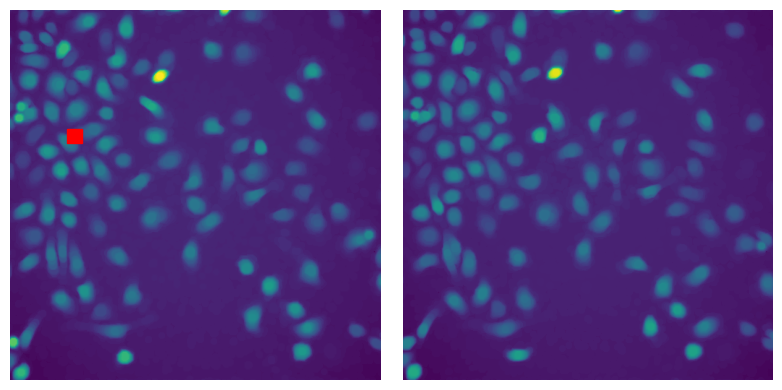

In [446]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(images['ctrl'][0], origin='lower')
rect = Rectangle(xy=(x_coords[0], y_coords[0]), width=20, height=20, color='r')
axs[0].add_patch(rect)
axs[1].imshow(images['ctrl'][1], origin='lower')
[axs[i].axis('off') for i in range(len(axs))]
plt.tight_layout()
plt.show()

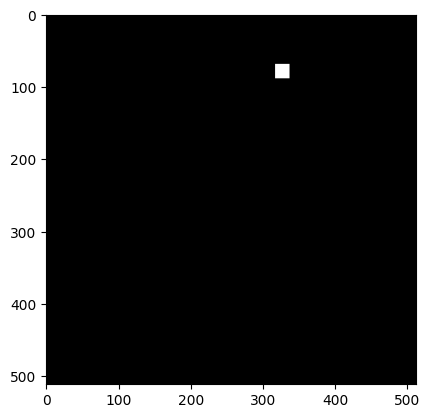

In [428]:
plt.imshow(seed, cmap='grey')